# Data Analysis

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pickle
from HandPosDataset import HandPosDataset

In [2]:
data_dir = '../../Data'

recordings = {}
for folder_name in os.listdir(data_dir):
    if folder_name.startswith('r'):
        for file_name in os.listdir(f'{data_dir}/{folder_name}'):
            if file_name.endswith('.h5'):
                if folder_name not in recordings:
                    recordings[folder_name] = []
                recordings[folder_name].append(f'{data_dir}/{folder_name}/{file_name}')
                
print(recordings)

{'r24': ['../../Data/r24/recordings_24_typing_enrollment03_text_typing03.h5', '../../Data/r24/recordings_24_typing_enrollment02_text_typing02.h5', '../../Data/r24/recordings_24_typing_enrollment01_text_typing01.h5'], 'r01': ['../../Data/r01/recordings_01_typing_enrollment01_text_typing01.h5', '../../Data/r01/recordings_01_typing_enrollment02_text_typing02.h5', '../../Data/r01/recordings_01_typing_enrollment03_text_typing03.h5'], 'r23': ['../../Data/r23/recordings_23_typing_enrollment03_text_typing03.h5', '../../Data/r23/recordings_23_typing_enrollment02_text_typing02.h5', '../../Data/r23/recordings_23_typing_enrollment01_text_typing01.h5'], 'r04': ['../../Data/r04/recordings_04_typing_enrollment03_text_typing03.h5', '../../Data/r04/recordings_04_typing_enrollment02_text_typing02.h5', '../../Data/r04/recordings_04_typing_enrollment01_text_typing01.h5'], 'r25': ['../../Data/r25/recordings_25_typing_enrollment03_text_typing04.h5', '../../Data/r25/recordings_25_typing_enrollment03_text_typ

In [3]:
def calculate_recording_stats(recording_path):
    df = pd.read_hdf(path_or_buf=recording_path, key='df')
    
    # Calculate the number of key presses
    num_key_press = df['keys'].apply(lambda x: x.any()).sum()
    
    # Calculate the number of non-key presses
    num_non_key_press = len(df) - num_key_press
    
    # Calculate the average sequence length between two key presses
    sequence_lengths = []
    sequence_length = 0
    for key in df['keys']:
        if key.any():
            sequence_lengths.append(sequence_length)
            sequence_length = 0
        else:
            sequence_length += 1
    
    return {'num_key_press': num_key_press, 'num_non_key_press': num_non_key_press, 'avg_sequence_length': np.mean(sequence_lengths),
            'std_sequence_length': np.std(sequence_lengths)}

In [4]:
def calculate_recording_stats_per_person(person_name, recordings_dict):
    stats = []
    for recording in recordings_dict[person_name]:
        stats.append(calculate_recording_stats(recording))
    
    total_stats = {}
    for key in stats[0].keys():
        total_stats[key] = np.mean([stat[key] for stat in stats])
    
    return stats, total_stats

In [5]:
def calculate_recording_stats_for_all(recordings_dict):
    stats_dict = {}
    for person in tqdm(recordings_dict.keys()):
        stats_dict[person] = calculate_recording_stats_per_person(person, recordings_dict)
    
    return stats_dict

In [6]:
stats = calculate_recording_stats_for_all(recordings)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:41<00:00,  8.46s/it]


In [7]:
def plot_num_key_press_bar(stats_all):
    """
    
    :param stats_all: a dictionary containing the stats of all the recordings 
    :return: plot where y axis is the number of key presses and x axis is the person name
    """
    
    num_key_press = []
    person_names = []
    for person in stats_all.keys():
        num_key_press.append(stats_all[person][1]['num_key_press'])
        person_names.append(person)
    
    plt.bar(person_names, num_key_press)
    plt.xlabel('Person')
    plt.ylabel('Number of key presses')
    plt.title('Number of key presses per person')
    plt.show()

In [8]:
def plot_num_non_key_press_bar(stats_all):
    """
    
    :param stats_all: a dictionary containing the stats of all the recordings 
    :return: plot where y axis is the number of non-key presses and x axis is the person name
    """
    
    num_non_key_press = []
    person_names = []
    for person in stats_all.keys():
        num_non_key_press.append(stats_all[person][1]['num_non_key_press'])
        person_names.append(person)
    
    plt.bar(person_names, num_non_key_press)
    plt.xlabel('Person')
    plt.ylabel('Number of non-key presses')
    plt.title('Number of non-key presses per person')
    plt.show()

In [9]:
def plot_mean_avg_empty_seq_length(stats_all):
    """
    
    :param stats_all: a dictionary containing the stats of all the recordings 
    :return: plot where y axis is the average empty sequence length and x axis is the person name
    """
    
    avg_empty_seq_length = []
    person_names = []
    for person in stats_all.keys():
        avg_empty_seq_length.append(stats_all[person][1]['avg_sequence_length'])
        person_names.append(person)
    
    plt.bar(person_names, avg_empty_seq_length)
    plt.xlabel('Person')
    plt.ylabel('Average empty sequence length')
    plt.title('Average empty sequence length per person')
    plt.show()

In [10]:
def plot_avg_stats(stats_all):
    avg_presses = []
    avg_non_presses = []
    avg_seq_length = []
    
    for person in stats_all.keys():
        avg_presses.append(stats_all[person][1]['num_key_press'])
        avg_non_presses.append(stats_all[person][1]['num_non_key_press'])
        avg_seq_length.append(stats_all[person][1]['avg_sequence_length'])
        
    avg_key_press = np.mean(avg_presses)
    avg_non_key_press = np.mean(avg_non_presses)
    avg_sequence_length = np.mean(avg_seq_length)
    
    # plt.bar(['Average key presses', 'Average non-key presses'], [avg_key_press, avg_non_key_press])
    
    # plot the avg_sequence_length in the same plot on the right side, with a different scale
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(['Average \nkey presses', 'Average \nnon-key presses'], [avg_key_press, avg_non_key_press])
    ax2.bar(['Average sequence length'], [avg_sequence_length], color='r')
    ax.set_ylabel('Number of presses', color='b')
    ax2.set_ylabel('Average sequence length', color='r')
    
    
    plt.show()

In [11]:
def plot_all(stats_all):
    plot_num_key_press_bar(stats_all)
    plot_num_non_key_press_bar(stats_all)
    plot_mean_avg_empty_seq_length(stats_all)
    plot_avg_stats(stats_all)

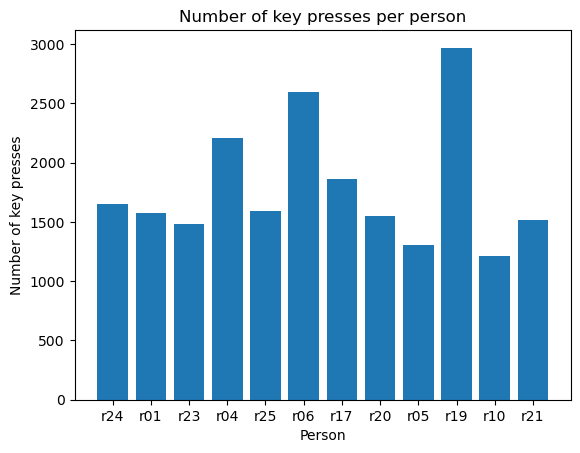

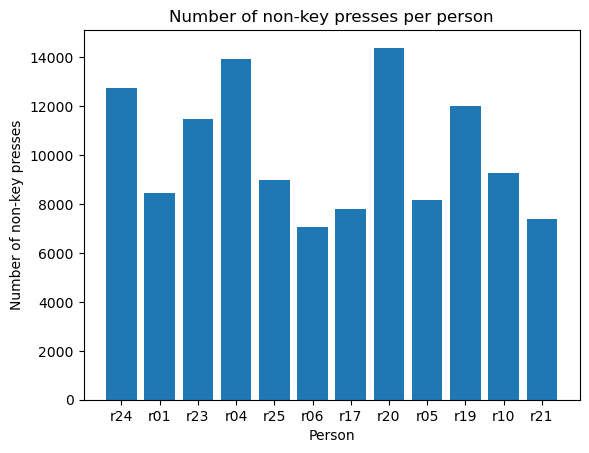

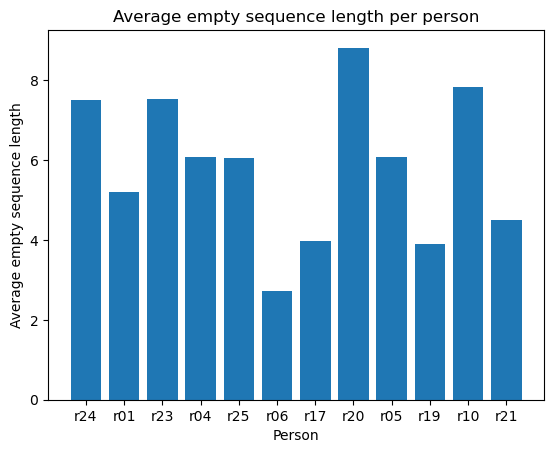

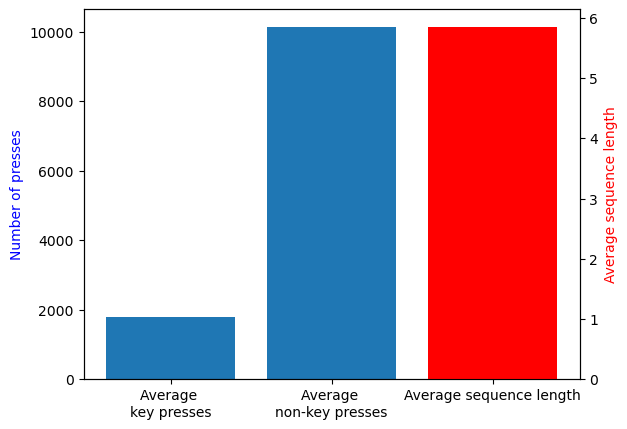

In [12]:
plot_all(stats)

## Dataset analysis

In [13]:
def calculate_num_key_presses(data):
    num_key_presses = []
    for input_data, target_data in data:
        num_key_presses.append(target_data.sum().item())
    
    return num_key_presses

def plot_key_presses_hist(data, dataset_name):
    num_key_presses_list = calculate_num_key_presses(data)
    
    total_length = 0
    lengths = []
    for input_data, target_data in data:
        total_length += len(target_data.view(-1))
        lengths.append(len(target_data.view(-1)))
        
    avg_seq_length = np.mean(lengths)
    
    avg_num_key_presses = np.mean(num_key_presses_list)
    total_num_key_presses = sum(num_key_presses_list)
    total_non_key_presses = total_length - total_num_key_presses
    
    print(f'Average number of key presses is {avg_num_key_presses} for average sequence length of {avg_seq_length}')
    
    plt.bar(['Key presses', 'Non-key presses'], [total_num_key_presses, total_non_key_presses])
    plt.xlabel('Type')
    plt.ylabel('Number of presses')
    plt.title(f'Number of key presses in \n {dataset_name} dataset')
    plt.show()

### Dataset many

In [14]:
data_dir = './data/regular'

with open(f'{data_dir}/train.pkl', 'rb') as f:
    train_data_many: HandPosDataset = pickle.load(f)
with open(f'{data_dir}/valid.pkl', 'rb') as f:
    valid_data_many: HandPosDataset = pickle.load(f)
with open(f'{data_dir}/test.pkl', 'rb') as f:
    test_data_many: HandPosDataset = pickle.load(f)
    
train_data_many.update_dataset_type('many')
valid_data_many.update_dataset_type('many')
test_data_many.update_dataset_type('many')

train_data_many.update_seq_length(10)
valid_data_many.update_seq_length(10)
test_data_many.update_seq_length(10)

Average number of key presses is 1.5089337237384854 for average sequence length of 10.0


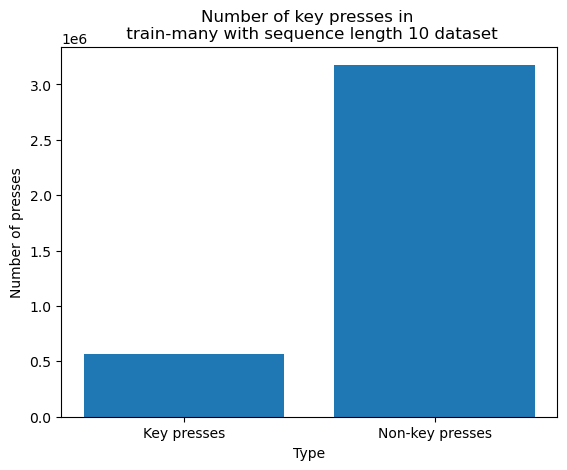

In [15]:
plot_key_presses_hist(train_data_many, 'train-many with sequence length 10')

Average number of key presses is 1.6851716266850425 for average sequence length of 10.0


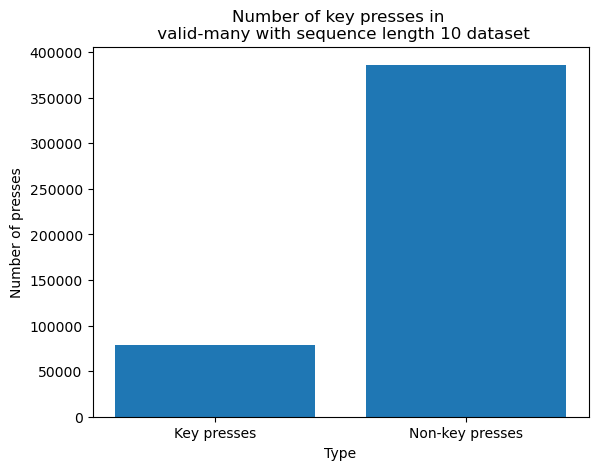

In [16]:
plot_key_presses_hist(valid_data_many, 'valid-many with sequence length 10')

Average number of key presses is 1.3892679566929982 for average sequence length of 10.0


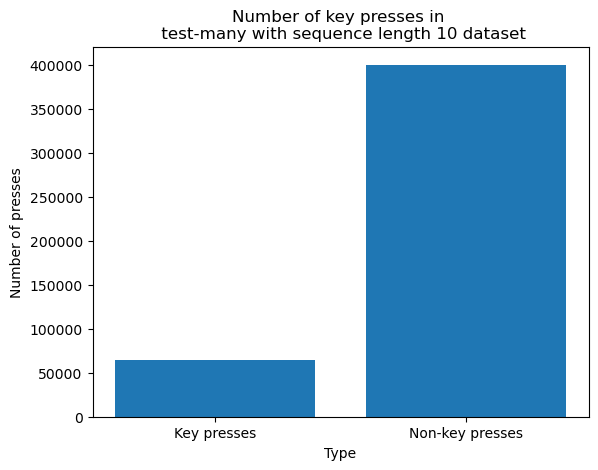

In [17]:
plot_key_presses_hist(test_data_many, 'test-many with sequence length 10')

### Dataset one

In [18]:
data_dir = './data/regular'

with open(f'{data_dir}/train.pkl', 'rb') as f:
    train_data_one: HandPosDataset = pickle.load(f)
with open(f'{data_dir}/valid.pkl', 'rb') as f:
    valid_data_one: HandPosDataset = pickle.load(f)
with open(f'{data_dir}/test.pkl', 'rb') as f:
    test_data_one: HandPosDataset = pickle.load(f)

train_data_one.update_dataset_type('one')
valid_data_one.update_dataset_type('one')
test_data_one.update_dataset_type('one')

train_data_one.update_seq_length(10)
valid_data_one.update_seq_length(10)
test_data_one.update_seq_length(10)

Average number of key presses is 0.151037102737823 for average sequence length of 1.0


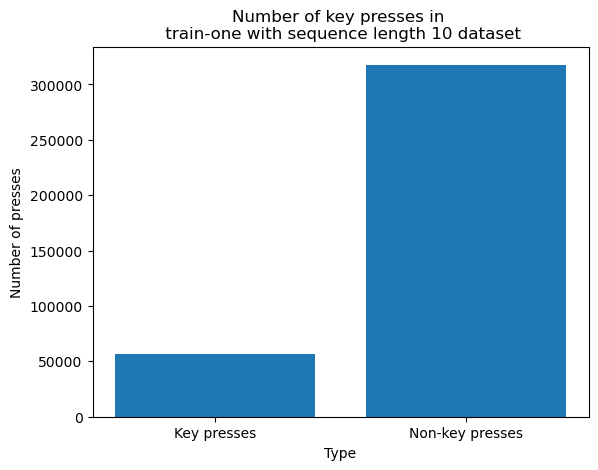

In [19]:
plot_key_presses_hist(train_data_one, 'train-one with sequence length 10')

Average number of key presses is 0.16835350359619278 for average sequence length of 1.0


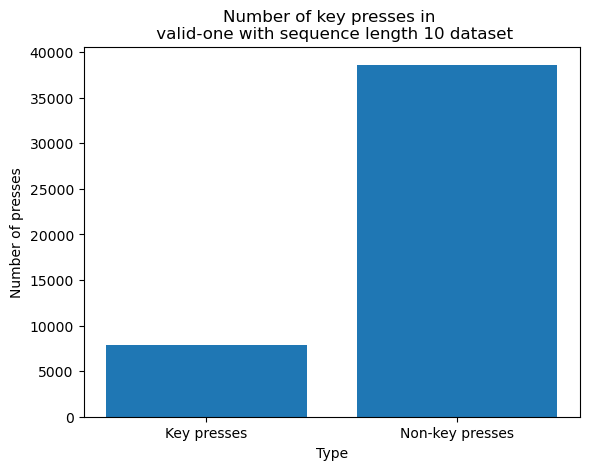

In [20]:
plot_key_presses_hist(valid_data_one, 'valid-one with sequence length 10')

Average number of key presses is 0.1378419681870036 for average sequence length of 1.0


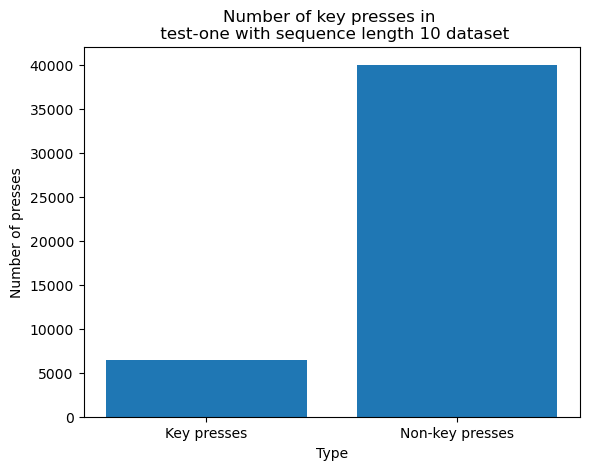

In [21]:
plot_key_presses_hist(test_data_one, 'test-one with sequence length 10')

# Trying to find the problem + how to solve it

We have highly imbalanced dataset.
15% of the data is key presses and 85% is non-key presses.

We want to achieve high AUC and high recall. Recall is important metric if we want to minimize the number of false negatives, therefore we want to label 1 as much as possible. In contrast, precision is higher if the number of false positives is minimized, but we less  care about that.

There are few ways to solve regular imbalanced dataset:
1. Loss weighting - we can weight the loss function so that the loss of the minority class is higher.
2. Filtering using oversampling or undersampling - we can filter the data so that the number of samples in each class is the same.
3. Focal loss - we can use focal loss which is a modification of cross entropy loss that puts more emphasis on the hard examples.   

First we want to see how we can filter the data, and what can we learn from that.

* Do we really need RNN-like network to solve this problem? Maybe we can use SVM or MLP to solve this problem. *
* I am not sure that the temporal information is important in this problem, perhaps we can use a simple MLP to solve this problem. * 

In [22]:
with open('./data/regular/train.pkl', 'rb') as f:
    train_data: HandPosDataset = pickle.load(f)

In [23]:
df_list = train_data.df_list
df = df_list[0]

In [24]:
df['press'].value_counts()

press
0    12795
1     1767
Name: count, dtype: int64

In [25]:
def calculate_avg_distance(df_, column_):
    distances = []
    for i in range(1, len(df_)):
        distances.append(np.linalg.norm(np.array(df_[column_].iloc[i]) - np.array(df_[column_].iloc[i - 1])))
    
    return np.mean(distances)

print('Average distance between two samples for thumb3_rel:', calculate_avg_distance(df, 'thumb3_rel'))
print('Average distance between two samples for thumb4_rel:', calculate_avg_distance(df, 'thumb4_rel'))

Average distance between two samples for thumb3_rel: 0.002677944110304202
Average distance between two samples for thumb4_rel: 0.0031837545107294236


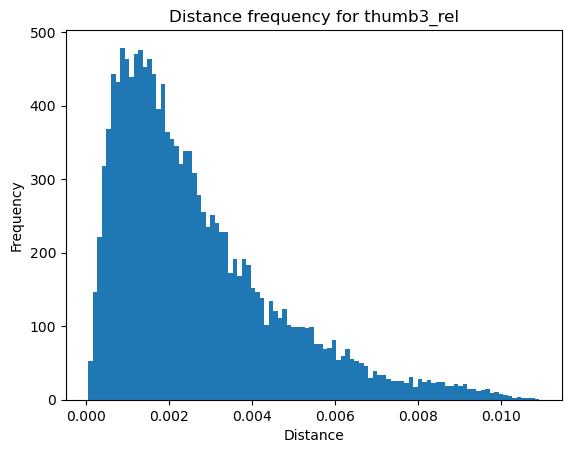

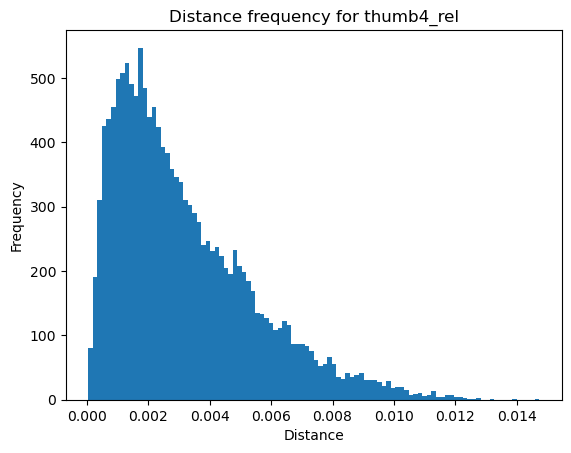

In [26]:
def plot_distance_freq(df_, column_):
    distances = []
    for i in range(1, len(df_)):
        distances.append(np.linalg.norm(np.array(df_[column_].iloc[i]) - np.array(df_[column_].iloc[i - 1])))
    
    plt.hist(distances, bins=100)
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.title(f'Distance frequency for {column_}')
    plt.show()
    
plot_distance_freq(df, 'thumb3_rel')
plot_distance_freq(df, 'thumb4_rel')

In [27]:
def calculate_transition_rows(df_):
    transitions_count = 0
    
    for i in range(1, len(df_)):
        if df_['press'].iloc[i] != df_['press'].iloc[i - 1]:
            transitions_count += 1
            
    return transitions_count

print('Number of transitions:', calculate_transition_rows(df))
print('NUmber of key presses:', df['press'].sum())
print('Number of rows:', len(df))

Number of transitions: 186
NUmber of key presses: 1767
Number of rows: 14562


In [28]:
def calculate_average_pressed_sequence(df_):
    sequence_lengths = []
    
    curr_row = 0
    while curr_row < len(df_):
        if df_['press'].iloc[curr_row] == 1:
            sequence_length = 0
            while curr_row < len(df_) and df_['press'].iloc[curr_row] == 1:
                sequence_length += 1
                curr_row += 1
            sequence_lengths.append(sequence_length)
        else:
            curr_row += 1
            
    return np.mean(sequence_lengths)

print('Average pressed sequence:', calculate_average_pressed_sequence(df))

Average pressed sequence: 19.0


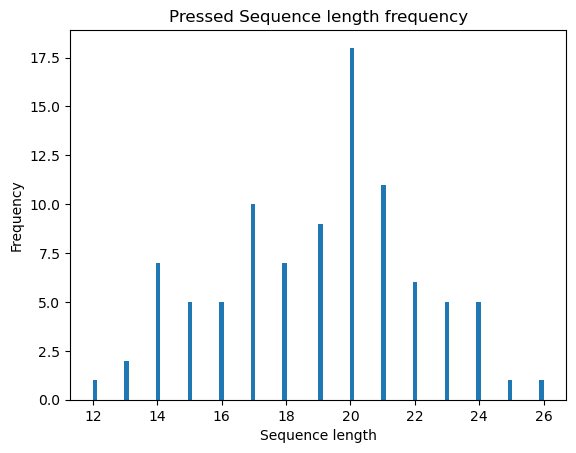

In [29]:
def plot_pressed_sequence_length_freq(df_):
    sequence_lengths = []
    
    curr_row = 0
    while curr_row < len(df_):
        if df_['press'].iloc[curr_row] == 1:
            sequence_length = 0
            while curr_row < len(df_) and df_['press'].iloc[curr_row] == 1:
                sequence_length += 1
                curr_row += 1
            sequence_lengths.append(sequence_length)
        else:
            curr_row += 1
            
    plt.hist(sequence_lengths, bins=100)
    plt.xlabel('Sequence length')
    plt.ylabel('Frequency')
    plt.title('Pressed Sequence length frequency')
    plt.show()
    
plot_pressed_sequence_length_freq(df)

In [30]:
def calculate_avg_distance_diff_for_pressed_seq(df_):
    distance_diff_dict = {'thumb3_rel': [], 'thumb4_rel': []}
    
    curr_row = 0
    while curr_row < len(df_):
        if df_['press'].iloc[curr_row] == 1:
            start_point_thumb3_rel = np.array(df_['thumb3_rel'].iloc[curr_row])
            start_point_thumb4_rel = np.array(df_['thumb4_rel'].iloc[curr_row])
            
            while curr_row < len(df_) and df_['press'].iloc[curr_row] == 1:
                curr_row += 1
                
            end_point_thumb3_rel = np.array(df_['thumb3_rel'].iloc[curr_row - 1])
            end_point_thumb4_rel = np.array(df_['thumb4_rel'].iloc[curr_row - 1])
            
            distance_diff_dict['thumb3_rel'].append(np.linalg.norm(end_point_thumb3_rel - start_point_thumb3_rel))
            distance_diff_dict['thumb4_rel'].append(np.linalg.norm(end_point_thumb4_rel - start_point_thumb4_rel))
            
        else:
            curr_row += 1
            
    distance_diff_dict['thumb3_rel'] = np.mean(distance_diff_dict['thumb3_rel'])
    distance_diff_dict['thumb4_rel'] = np.mean(distance_diff_dict['thumb4_rel'])
            
    return distance_diff_dict

print('Average distance difference for pressed sequence:', calculate_avg_distance_diff_for_pressed_seq(df))

Average distance difference for pressed sequence: {'thumb3_rel': 0.03135030484175805, 'thumb4_rel': 0.03501350871822136}


In [31]:
def calculate_avg_distance_diff_for_not_pressed_seq(df_):
    distance_diff_dict = {'thumb3_rel': [], 'thumb4_rel': []}

    curr_row = 0
    while curr_row < len(df_):
        if df_['press'].iloc[curr_row] == 0:
            start_point_thumb3_rel = np.array(df_['thumb3_rel'].iloc[curr_row])
            start_point_thumb4_rel = np.array(df_['thumb4_rel'].iloc[curr_row])

            while curr_row < len(df_) and df_['press'].iloc[curr_row] == 0:
                curr_row += 1

            end_point_thumb3_rel = np.array(df_['thumb3_rel'].iloc[curr_row - 1])
            end_point_thumb4_rel = np.array(df_['thumb4_rel'].iloc[curr_row - 1])

            distance_diff_dict['thumb3_rel'].append(np.linalg.norm(end_point_thumb3_rel - start_point_thumb3_rel))
            distance_diff_dict['thumb4_rel'].append(np.linalg.norm(end_point_thumb4_rel - start_point_thumb4_rel))

        else:
            curr_row += 1

    distance_diff_dict['thumb3_rel'] = np.mean(distance_diff_dict['thumb3_rel'])
    distance_diff_dict['thumb4_rel'] = np.mean(distance_diff_dict['thumb4_rel'])

    return distance_diff_dict

print('Average distance difference for not pressed sequence:', calculate_avg_distance_diff_for_not_pressed_seq(df))

Average distance difference for not pressed sequence: {'thumb3_rel': 0.28936035631550605, 'thumb4_rel': 0.3195929480899893}


#### Idea for filtering the data

As we can see from the output above, the problem is that positive labels are clustered together, and the negative labels are also clustered together. Also, the distance between the two clusters is different, and the number of sample might be too much.

One approach is to sample the data such that the distance between two sampels will be equal to 50% of the average distance difference of the pressed sequences. That way we will not have too much zero samples, and we will have most of the time at least one sample from each key press sequence.

In [32]:
def is_rows_close(row1, row2, distance_diff_dict, threshold=0.5):
    thumb3_diff = np.linalg.norm(np.array(row1['thumb3_rel']) - np.array(row2['thumb3_rel']))
    thumb4_diff = np.linalg.norm(np.array(row1['thumb4_rel']) - np.array(row2['thumb4_rel']))
    
    if thumb3_diff < distance_diff_dict['thumb3_rel'] * threshold or thumb4_diff < distance_diff_dict['thumb4_rel'] * threshold:
        return True
    
    return False

def create_filtered_df(df_):
    avg_diff_dist_for_pressed_seq = calculate_avg_distance_diff_for_pressed_seq(df_)
    
    rows = []
   
    curr_row = 0
    while curr_row < len(df_):
        rows.append(df_.iloc[curr_row])
       
        next_row = curr_row + 1
        while next_row < len(df_) and is_rows_close(df_.iloc[curr_row], df_.iloc[next_row],  avg_diff_dist_for_pressed_seq):
           next_row += 1
           
        curr_row = next_row
    
    return pd.DataFrame(rows)

In [33]:
filtered_df = create_filtered_df(df)

In [34]:
filtered_df['press'].value_counts()

press
0    1810
1     175
Name: count, dtype: int64

In [35]:
print('Number of transitions:', calculate_transition_rows(filtered_df))

Number of transitions: 160


In [36]:
print('Average pressed sequence:', calculate_average_pressed_sequence(filtered_df))

Average pressed sequence: 2.1875


In [37]:
print('Average distance difference for pressed sequence:', calculate_avg_distance_diff_for_pressed_seq(filtered_df))

Average distance difference for pressed sequence: {'thumb3_rel': 0.02029381915581515, 'thumb4_rel': 0.023135963347131333}


In [38]:
print('Average distance difference for not pressed sequence:', calculate_avg_distance_diff_for_not_pressed_seq(filtered_df))

Average distance difference for not pressed sequence: {'thumb3_rel': 0.30073869779436335, 'thumb4_rel': 0.33343349276803835}


In [39]:
print('Average distance between two samples for thumb3_rel:', calculate_avg_distance(filtered_df, 'thumb3_rel'))
print('Average distance between two samples for thumb4_rel:', calculate_avg_distance(filtered_df, 'thumb4_rel'))

Average distance between two samples for thumb3_rel: 0.0182839355720684
Average distance between two samples for thumb4_rel: 0.02079361990179282


#### Another Idea - Maybe use MLP for classification. Is there a function between the coordinates and the actions?

In [40]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [41]:
def create_data(data_type):
    if data_type not in ['train', 'valid', 'test']:
        raise ValueError('Data type must be either train, valid or test')
    
    with open(f'./data/{data_type}.pkl', 'rb') as f:
        data: HandPosDataset = pickle.load(f)
        
    df_list = data.df_list
    
    X = []
    y = []
    
    for df in df_list:
        X += df['coords'].tolist()
        y += df['press'].tolist()
        
    return np.array(X), np.array(y)

In [42]:
X_train, y_train = create_data('train')
X_valid, y_valid = create_data('valid')
X_test, y_test = create_data('test')

FileNotFoundError: [Errno 2] No such file or directory: './data/train.pkl'

In [ ]:
classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, verbose=True, early_stopping=True)
classifier.fit(X_train, y_train)

In [ ]:
print(f'Accuracy: {classifier.score(X_test, y_test)}')

In [ ]:
from sklearn.metrics import precision_score, recall_score

y_pred = classifier.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

In [ ]:
print('Ground truth:')
print('Count of 0:', len(y_test) - y_test.sum())
print('Count of 1:', y_test.sum())

print()

print('Predictions:')
print('Count of 0:', len(y_pred) - y_pred.sum())
print('Count of 1:', y_pred.sum())